In [0]:
#Connect google drive
from google.colab import drive
drive.mount('/content/gdrive/')

import json
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import csv
import os
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import helper
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
#tf.enable_eager_execution() 

print("Tensorflow Version: ",tf.__version__)

!wget https://food-x.s3.amazonaws.com/annot.tar
!tar -xf annot.tar
!rm -r annot.tar
!wget https://food-x.s3.amazonaws.com/train.tar
!tar -xf train.tar
!rm -r train.tar
!wget https://food-x.s3.amazonaws.com/val.tar
!tar -xf val.tar
!rm -r val.tar
!wget https://food-x.s3.amazonaws.com/test.tar  
!tar -xf test.tar
!rm -r test.tar

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


Using TensorFlow backend.


Tensorflow Version:  1.13.1
--2019-06-03 18:49:41--  https://food-x.s3.amazonaws.com/annot.tar
Resolving food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)... 52.216.170.11
Connecting to food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)|52.216.170.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3123200 (3.0M) [application/x-tar]
Saving to: ‘annot.tar’

annot.tar           100%[===================>]   2.98M  13.7MB/s    in 0.2s    

2019-06-03 18:49:41 (13.7 MB/s) - ‘annot.tar’ saved [3123200/3123200]

--2019-06-03 18:49:45--  https://food-x.s3.amazonaws.com/train.tar
Resolving food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)... 52.216.98.195
Connecting to food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)|52.216.98.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370519040 (2.2G) [application/x-tar]
Saving to: ‘train.tar’

train.tar           100%[===================>]   2.21G  54.6MB/s    in 38s     

2019-06-03 18:50:24 (59.0 

In [0]:
#############################################################
#                                                           #
# Hyperparameters setup and initialization of key variables #
#                                                           #
#############################################################
base_dir = '.'
train_dir = os.path.join(base_dir, 'train_set')
validation_dir = os.path.join(base_dir, 'val_set')
test_dir = os.path.join(base_dir, 'test_set')

#Load model files
densenet201_model_file='/content/gdrive/My Drive/Colab Notebooks/iFood2019/DenseNet-201_model.json'
incresnetv2_model_file='/content/gdrive/My Drive/Colab Notebooks/iFood2019/InceptionResNetV2_model.json'
#Checkpoint files containing trained weights
checkpoint_file_incresnetv2 = '/content/gdrive/My Drive/Colab Notebooks/iFood2019/InceptionResNetV2_weights-improvement-04-0.74.hdf5'
checkpoint_file_densenet201 = '/content/gdrive/My Drive/Colab Notebooks/iFood2019/Densenet201_weights-improvement-02-0.68.hdf5'

# Number of classes in the dataset
num_classes = 251

# Batch size for training (change depending on how much memory you have)
BATCH_SIZE = 128

# Learning rate
learning_rate = 0.01

# Set the image size (typically 224x224 for most of the models, however for inception it has to be 299x299)
image_size = 299

In [0]:
#Load label to text mapping as well as labels from files to python dictionaries 
#Label mapping (mapping from category label to category name) from text file to a dictionary
cat_to_name = {}
with open("class_list.txt") as f:
    for line in f:
       (key, val) = line.split()
       cat_to_name[int(key)] = val

train_labels = pd.read_csv(os.path.join(base_dir,'train_info.csv'), header=None, dtype=str)
train_labels.columns = ["img_name","label"] # add header
val_labels = pd.read_csv(os.path.join(base_dir,'val_info.csv'), header=None, dtype=str)
val_labels.columns = ["img_name","label"] # add header
test_labels = pd.read_csv(os.path.join(base_dir,'test_info.csv'), header=None, dtype=str)
test_labels.columns = ["img_name"] # add header

In [0]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow validation images in batches of batch_size using valid_datagen generator
validation_generator = valid_datagen.flow_from_dataframe(dataframe = val_labels,
                                                    directory = validation_dir,
                                                    x_col = 'img_name',
                                                    y_col = 'label',
                                                    class_mode = 'categorical',
                                                    batch_size = 1, #can be BATCH_SIZE or canbe set to 1 if you would like to predict for entire dataset
                                                    shuffle = False,
                                                    target_size = (image_size, image_size)
                                                   )
# Flow test images in batches of batch_size using valid_datagen generator
test_generator = test_datagen.flow_from_dataframe(dataframe = test_labels,
                                                   directory = test_dir,
                                                   x_col = 'img_name',
                                                   class_mode = None,
                                                   batch_size = 1,
                                                   shuffle = False,
                                                   target_size = (image_size, image_size)
                                                  )

Found 11994 images belonging to 251 classes.
Found 28377 images.


In [0]:
# load json and create DenseNet201 model
from keras.models import model_from_json
json_file = open(densenet201_model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
densenet201_model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
densenet201_model.load_weights(checkpoint_file_densenet201)
print("Loaded DenseNet201 model from disk")
#densenet201_model.summary() #display model on the screen

# load json and create InceptionResNetV2 model
from keras.models import model_from_json
json_file = open(incresnetv2_model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
incresnetv2_model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
incresnetv2_model.load_weights(checkpoint_file_incresnetv2)
print("Loaded InceptionResNetV2 model from disk")
#incresnetv2_model.summary()

Loaded DenseNet201 model from disk
Loaded InceptionResNetV2 model from disk


In [0]:
from tensorflow.keras.optimizers import SGD

densenet201_model.compile(optimizer = SGD(lr=learning_rate, momentum=0.9, decay=1e-6), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

incresnetv2_model.compile(optimizer = SGD(lr=learning_rate, momentum=0.9, decay=1e-6), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])


In [0]:
#Predict the output for validation_generator
#You need to reset the test_generator before whenever you call the predict_generator. 
#This is important, if you forget to reset the test_generator you will get outputs in a weird order.
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()

#pred_val_incresnetv2=incresnetv2_model.predict_generator(validation_generator,
#                             use_multiprocessing = False,
#                             steps=STEP_SIZE_TEST,
#                             verbose=1)

# Flow validation images in batches of batch_size using valid_datagen generator
validation_generator_den = valid_datagen.flow_from_dataframe(dataframe = val_labels,
                                                    directory = validation_dir,
                                                    x_col = 'img_name',
                                                    y_col = 'label',
                                                    class_mode = 'categorical',
                                                    batch_size = 1, #can be BATCH_SIZE or canbe set to 1 if you would like to predict for entire dataset
                                                    shuffle = False,
                                                    target_size = (224, 224)
                                                   )
# Flow test images in batches of batch_size using valid_datagen generator
test_generator_den = test_datagen.flow_from_dataframe(dataframe = test_labels,
                                                   directory = test_dir,
                                                   x_col = 'img_name',
                                                   class_mode = None,
                                                   batch_size = 1,
                                                   shuffle = False,
                                                   target_size = (224, 224)
                                                  )

#pred_val_densenet201=densenet201_model.predict_generator(validation_generator_den,
#                             use_multiprocessing = False,
#                             steps=STEP_SIZE_TEST,
#                             verbose=1)

Found 11994 images belonging to 251 classes.
Found 28377 images.


In [0]:
#Calculate mean value from two models
pred_val_mean = np.mean([pred_val_densenet201,pred_val_incresnetv2], axis=0)
print(pred_val_mean[0][1])
print(pred_val_densenet201[0][1])
print(pred_val_incresnetv2[0][1])

0.0051192692
0.003633394
0.0066051446


In [0]:
#Top1- scores
predicted_class_indices=np.argmax(pred_val_mean,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


filenames=validation_generator.filenames
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})

ValueError: ignored

In [0]:
##############################################
# Prepare dataframe for validation generator #
##############################################
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items()) # change order to proper (key,value) pair so value is now the label and key is value taken from generator
strings = list()
for i in range(pred_val_incresnetv2.shape[0]):
#top1, top2, top3 are to top class indices from Keras generator that need to be converted to labels
  top1 = labels[pred_val_incresnetv2[i].argsort()[-3:][::-1][0]] #pred[i].argsort()[-3:][::-1] gives top-3 predictions
  top2 = labels[pred_val_incresnetv2[i].argsort()[-3:][::-1][1]]
  top3 = labels[pred_val_incresnetv2[i].argsort()[-3:][::-1][2]]
  
  strings.append(top1+' '+top2+' '+top3)
  
submission = pd.DataFrame()
submission['img_name'] = validation_generator.filenames
submission['label'] = strings
#submission.to_csv("submission.csv", index=False)

submission
#!kaggle competitions submit -c ifood-2019-fgvc6 -f submission.csv -m "version 0.2"


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
#Predict the output for test_generator
#You need to reset the test_generator before whenever you call the predict_generator. 
#This is important, if you forget to reset the test_generator you will get outputs in a weird order.
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

#pred_test_incresnetv2=incresnetv2_model.predict_generator(test_generator,
#                             use_multiprocessing = False,
#                             steps=STEP_SIZE_TEST,
 #                            verbose=1)

pred_test_densenet201=densenet201_model.predict_generator(test_generator_den,
                             use_multiprocessing = False,
                             steps=STEP_SIZE_TEST,
                             verbose=1)
#Calculate mean value from two models
pred_test_mean = np.mean([pred_test_densenet201,pred_test_incresnetv2], axis=0)


28377/28377 [==============================] - 1912s 67ms/step


In [0]:
##############################################
# Submission of results to kaggle server     #
##############################################
os.environ["KAGGLE_USERNAME"] = "technic2017"
os.environ["KAGGLE_KEY"] = "db6bd82821e7ecd01f6f83effc3cc41b"

labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

strings = list()
for i in range(pred_test_mean.shape[0]):
#top1, top2, top3 are to top class indices from Keras generator that need to be converted to labels
  top1 = labels[pred_test_mean[i].argsort()[-3:][::-1][0]]#pred[i].argsort()[-3:][::-1] gives top-3 predictions
  top2 = labels[pred_test_mean[i].argsort()[-3:][::-1][1]]
  top3 = labels[pred_test_mean[i].argsort()[-3:][::-1][2]]
  
  strings.append(top1+' '+top2+' '+top3)
  
submission = pd.DataFrame()
submission['img_name'] = test_generator.filenames
submission['label'] = strings
submission.to_csv("submission.csv", index=False)

!cat submission.csv
!kaggle competitions submit -c ifood-2019-fgvc6 -f submission.csv -m "version 0.6"

img_name,label
test_024088.jpg,212 113 111
test_024089.jpg,51 232 106
test_024090.jpg,73 234 197
test_024091.jpg,236 144 31
test_024092.jpg,231 64 230
test_024093.jpg,246 213 159
test_024094.jpg,233 33 53
test_024095.jpg,230 206 171
test_024096.jpg,218 195 197
test_024097.jpg,215 93 206
test_024098.jpg,222 165 154
test_024099.jpg,93 249 215
test_024100.jpg,245 56 212
test_024101.jpg,93 215 122
test_024102.jpg,216 45 91
test_024103.jpg,91 216 200
test_024104.jpg,217 230 163
test_024105.jpg,73 2 238
test_024106.jpg,245 8 137
test_024107.jpg,249 215 93
test_024108.jpg,93 215 240
test_024109.jpg,211 73 231
test_024110.jpg,217 159 230
test_024111.jpg,219 146 203
test_024112.jpg,218 195 20
test_024113.jpg,236 219 146
test_024114.jpg,226 11 43
test_024115.jpg,161 119 247
test_024116.jpg,127 199 246
test_024117.jpg,223 146 115
test_024118.jpg,220 225 156
test_024119.jpg,225 115 188
test_024120.jpg,241 231 77
test_024121.jpg,164 249 175
test_024122.jpg,218 197 15
test_024123.jpg,227 119 48
test

<Figure size 432x288 with 0 Axes>

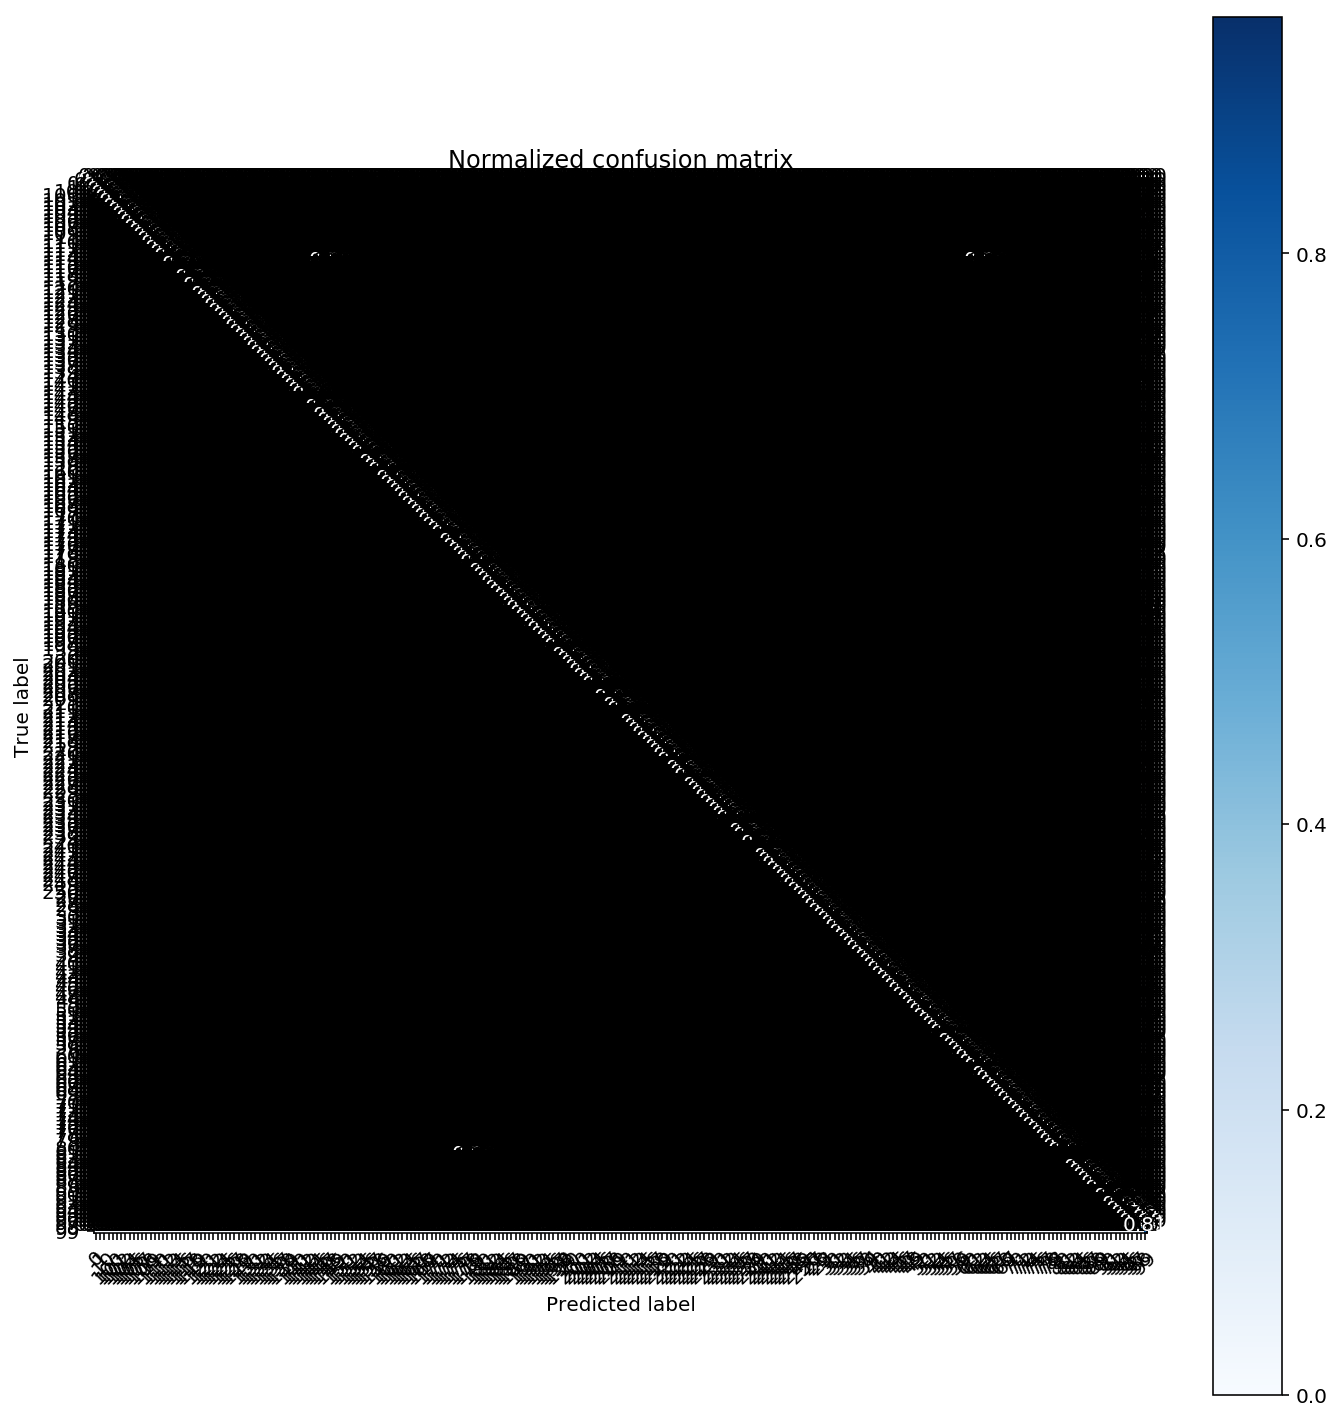

In [0]:
# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [0]:
predicted_class_indices=np.argmax(pred_test,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

In [0]:
###############################################################
# Loop through all files in given folder and make predictions #
###############################################################
from tensorflow.python.keras.applications.resnet50 import preprocess_input
#from tensorflow.python.keras.preprocessing import image
import glob
from skimage import transform

def get_files(path):
    if os.path.isdir(path):
        files = glob.glob(os.path.join(path, '*'))
    elif path.find('*') > 0:
        files = glob.glob(path)
    else:
        files = [path]

    #files = [f for f in files if f.endswith('JPG') or f.endswith('jpg')]
    if not len(files):
        sys.exit('No images found by the given path!')

    return files
  
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (image_size, image_size, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image
  
  
def predict_all(model,img_dir):
    '''Predicts class based on the input image
       model - keras model
       img_dir - directory containing test images'''

    files = get_files(img_dir)
    font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }


    for f in files:
      image = load(f)
      pred_image = model.predict(image)
      the_pred = np.argmax(pred_image)
      predicted = cat_to_name[the_pred]
      val_pred = np.max(pred_image)
      plt.title(('predicted: ' + predicted + ' | class id: ' + str(the_pred) + ' | Probability: [' + str(val_pred) + ']'), fontdict=font)
      plt.imshow(image[0])
      
    return 0
  
#predict_all(model,validation_dir)

pred:  [2.36e-07 2.79e-07 5.54e-07 7.29e-07 2.23e-07 1.02e-04 9.24e-06 6.16e-04
 1.22e-06 2.30e-06 4.79e-05 8.84e-06 8.55e-07 4.53e-07 7.20e-06 2.67e-06
 2.28e-07 2.26e-06 1.62e-06 6.17e-06 6.22e-06 1.69e-02 4.57e-05 9.48e-08
 1.39e-03 5.06e-07 1.10e-07 5.03e-02 1.07e-05 2.03e-06 7.15e-05 8.18e-07
 2.56e-06 5.96e-05 6.59e-04 5.74e-06 1.57e-05 5.96e-08 4.86e-04 4.53e-06
 1.87e-05 3.61e-07 4.59e-06 3.12e-06 2.46e-07 4.06e-06 1.85e-04 6.01e-05
 8.35e-06 1.39e-03 1.67e-05 1.13e-07 4.35e-04 2.38e-07 5.64e-03 2.30e-04
 1.35e-06 5.52e-07 9.49e-05 2.38e-03 7.45e-06 3.47e-07 1.67e-03 3.47e-09
 2.86e-07 2.78e-05 2.87e-03 4.83e-06 2.14e-04 1.97e-07 2.03e-07 3.24e-06
 4.75e-05 9.46e-06 3.40e-06 3.21e-06 1.18e-03 7.37e-06 8.57e-06 3.94e-04
 5.46e-04 1.84e-05 3.40e-08 1.93e-08 4.45e-06 2.73e-03 7.19e-06 5.18e-04
 2.60e-05 3.00e-06 7.19e-07 2.00e-03 1.19e-04 9.91e-05 1.96e-05 1.37e-07
 1.69e-06 1.91e-06 2.63e-05 4.54e-07 2.44e-05 1.62e-07 2.78e-04 8.30e-07
 4.10e-05 6.52e-06 4.11e-06 5.10e-04 3.38e-0

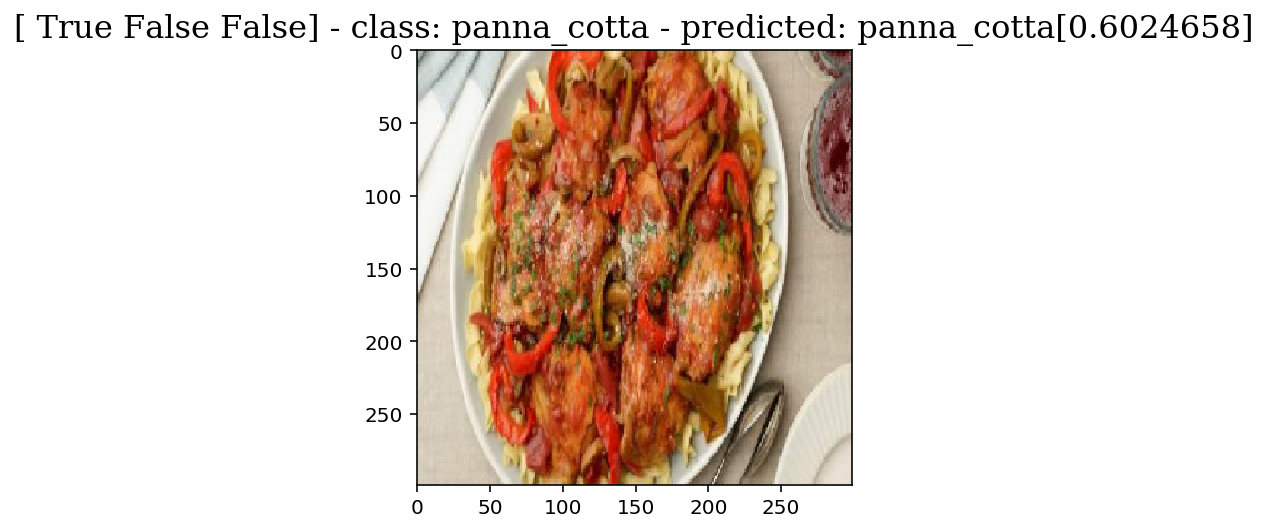

In [0]:
def predict_one(model,generator):
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

    image_batch, classes_batch = next(generator)
    predicted_batch = model.predict(image_batch)
    for k in range(1):
      image = image_batch[k]
      pred = predicted_batch[k]
      print("pred: ",pred)
      the_pred = np.argmax(pred)
      print("the_pred: ",the_pred)
      the_pred=pred.argsort()[-3:][::-1]
      print("the_pred_top_3: ",the_pred)
      print(validation_generator.filenames[k])
      predicted = cat_to_name[the_pred[0]]
      print("predicted: ",predicted)
      val_pred = max(pred)
      print("val_pred: ",val_pred)
      the_class = np.argmax(classes_batch[k])
      print("classes_batch[k]: ",classes_batch[k])
      print("the_class: ",the_class)
      value = cat_to_name[np.argmax(classes_batch[k])]
      print("value: ",value)
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title((str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']'), fontdict=font)
      plt.imshow(image)
predict_one(model, validation_generator)

In [0]:
#For each element print indexes of numpy array elements containing top-3 numbers with the highest value (top-3 accuracy)
#validation_generator.reset()
for i in range(pred.shape[0]):
  print(validation_generator.filenames[i])
  print(pred[i].argsort()[-3:][::-1]) 
  print('[' + cat_to_name[pred[i].argsort()[-3:][::-1][0]] + ' ' + cat_to_name[pred[i].argsort()[-3:][::-1][1]] + ' ' + cat_to_name[pred[i].argsort()[-3:][::-1][2]] + ']')
  

Number of true predictions:  0
Number of all predictions:  1
Accuracy:  0.0


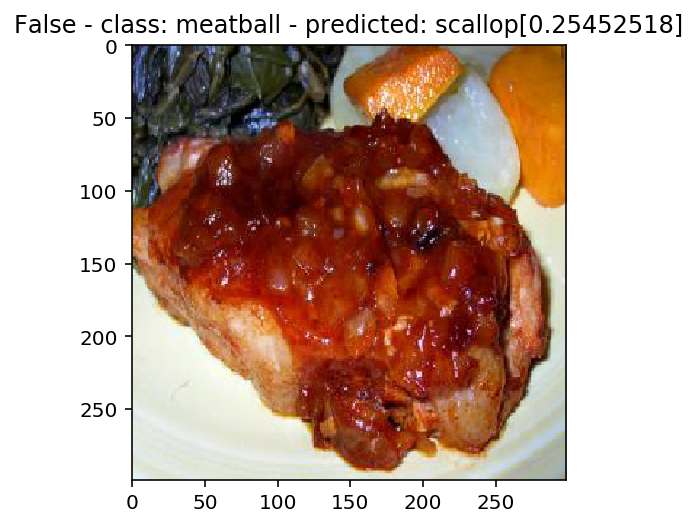

In [0]:
def predict_one(model,generator):
    labels = (generator.class_indices)
    labels = dict((v,k) for k,v in labels.items()) # change order to proper (key,value) pair so value is now the label and key is value taken from generator
    image_batch, classes_batch = next(generator)
    predicted_batch = model.predict(image_batch)
    true_pred=0
    all_pred=0
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = cat_to_name[the_pred]
      val_pred = max(pred)
      the_class = np.argmax(classes_batch[k])
      value = cat_to_name[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      if(isTrue): true_pred+=1
      all_pred+=1
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)
    print('Number of true predictions: ',true_pred)
    print('Number of all predictions: ', all_pred)
    print('Accuracy: ', true_pred/all_pred)
    
predict_one(model,validation_generator)

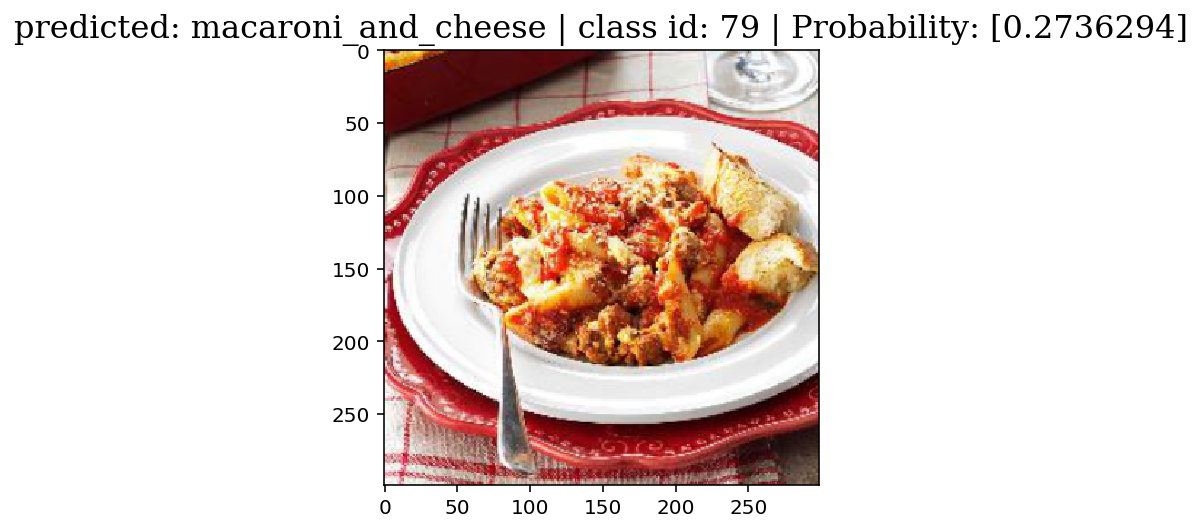

In [0]:
#Predict single image loaded from drive

from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (image_size, image_size, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(os.path.join(validation_dir, 'val_010330.jpg'))
pred_image = model.predict(image)
the_pred = np.argmax(pred_image)
predicted = cat_to_name[the_pred]
val_pred = np.max(pred_image)
font = {'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 16,
    }

plt.title(('predicted: ' + predicted + ' | class id: ' + str(the_pred) + ' | Probability: [' + str(val_pred) + ']'), fontdict=font)
plt.imshow(image[0])

In [0]:
cat_to_name

{0: 'macaron',
 1: 'beignet',
 2: 'cruller',
 3: 'cockle_food',
 4: 'samosa',
 5: 'tiramisu',
 6: 'tostada',
 7: 'moussaka',
 8: 'dumpling',
 9: 'sashimi',
 10: 'knish',
 11: 'croquette',
 12: 'couscous',
 13: 'porridge',
 14: 'stuffed_cabbage',
 15: 'seaweed_salad',
 16: 'chow_mein',
 17: 'rigatoni',
 18: 'beef_tartare',
 19: 'cannoli',
 20: 'foie_gras',
 21: 'cupcake',
 22: 'osso_buco',
 23: 'pad_thai',
 24: 'poutine',
 25: 'ramen',
 26: 'pulled_pork_sandwich',
 27: 'bibimbap',
 28: 'chicken_kiev',
 29: 'apple_pie',
 30: 'risotto',
 31: 'fruitcake',
 32: 'chop_suey',
 33: 'haggis',
 34: 'scrambled_eggs',
 35: 'frittata',
 36: 'scampi',
 37: 'sushi',
 38: 'orzo',
 39: 'fritter',
 40: 'nacho',
 41: 'beef_stroganoff',
 42: 'beef_wellington',
 43: 'spring_roll',
 44: 'savarin',
 45: 'crayfish_food',
 46: 'souffle',
 47: 'adobo',
 48: 'streusel',
 49: 'deviled_egg',
 50: 'escargot',
 51: 'club_sandwich',
 52: 'carrot_cake',
 53: 'falafel',
 54: 'farfalle',
 55: 'terrine',
 56: 'poached_eg